# Composite loss, version 0

In [ ]:
# Purpose:
    # Inject platform labels into keras.Model class to drive model system
    # platform-corrected encoding while preserving cancer-type signal

# 1/3 code files
    # y_mapping_v0: auto download data, map y targets, structure X matrices
    # eval_plots_v0: logistic regression, euclidean distance, and UMAP plots

# Imports

In [1]:
import pandas as pd
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

from scipy.spatial.distance import euclidean
from matplotlib.colors import ListedColormap
from joypy import joyplot

import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/karlberb/miniforge3/envs/py310tf210/lib/python3

### Functions

#### Original distance

In [ ]:
def distance_from_other_types(sample, features, df): # 'cl_ln_gxp', run 2 <-- WHAT DOES THIS MEAN?
    other_types = df[df['cancer_type'] != sample['cancer_type']]
    mean_features_other_types = other_types[features].mean()
    distance = euclidean(sample[features], mean_features_other_types)
    return distance

In [ ]:
del(distance_from_other_types)

#### Data mode specific distance functions

In [ ]:
# Logistic regression function hold point
    # currently in-line later

In [ ]:
# Euclidean distance, cancer type
def cncr_typ_dist(sample, features, df):
    other_types = df[df['cancer_type'] != sample['cancer_type']]
    mean_features_other_types = other_types[features].mean()
    distance = euclidean(sample[features], mean_features_other_types)
    return distance

In [ ]:
# Euclicean distance, model type
def mdl_typ_dist(sample, features, df):
    other_types = df[df['model_type'] != sample['model_type']]
    mean_features_other_types = other_types[features].mean()
    distance = euclidean(sample[features], mean_features_other_types)
    return distance

### Updated version of VAE

In [2]:
# Define the Sampling Layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
# Define the VAE class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        # Define self.distance_quant
        # self.model_system_distance_tracker = keras.metrics.Mean(name="distance_loss") # added
    
        # Define self.logreg_quant (hold)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            # self.model_system_distance_tracker, # added
        ]

    # Devel the distance function outside class with selected_df <- last col as labels
    # REPLACE THE NESTED LAMBA DISTANCE FUNCTION HERE
    # def calc_model_dist(latent_tumor, latent_cell_line): # added
    #     return distance_vector
    
    def train_step(self, data):
            # Separate out the labels
        # labels = data.iloc[:, -1]  # Assuming labels are the last column
        # x = data.iloc[:, :-1]  # Rest of the columns are features
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) # original, unlabled X matrix
            # z_mean, z_log_var, z = self.encoder(x) # added line replacing data with x
            reconstruction = self.decoder(z)
            # print(z)
            reconstruction_loss = data.shape[1] * keras.losses.binary_crossentropy(data, reconstruction)
            # reconstruction_loss = data.shape[1] * keras.losses.binary_crossentropy(x, reconstruction) # added line replacing data with x
            
            # print(reconstruction_loss)
            kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            # print(kl_loss)
            total_loss = reconstruction_loss + kl_loss

            # composite_loss = total_loss + distance_loss
            # + ctd + mtd <-- cancer and model type distance
            # + ctlr + mtlr <-- cancer and model type logistic regression

        grads = tape.gradient(total_loss, self.trainable_weights) # original, replaced below
        # grads = tape.gradient(composite_loss, self.trainable_weights) # added composite loss to include cancer model system distance calculation
        
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [4]:
# Build Encoder
def build_encoder(feature_dim, latent_dim):
    encoder_inputs = keras.Input(shape=(feature_dim,), name="input_1")
    x = keras.layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_dense_1")(encoder_inputs)
    x = keras.layers.BatchNormalization(name="batchnorm")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [5]:
# Build Decoder
def build_decoder(feature_dim, latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = keras.layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')(latent_inputs)
    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

In [6]:
# Parameters
latent_dim = 50
learning_rate = 0.001
epochs = 30
batch_size = 128

# Data

In [ ]:
# Output from y_mapping_v0
# toggle and inspect data type object for encoding

In [ ]:
d_typ_obj = pd.read_csv('../results/pltfrm_cnctns/cl_cp_cnvr_996.tsv',
                       sep = '\t', index_col = 0)
d_typ = 'cnvr'

In [7]:
d_typ_obj = pd.read_csv('../results/pltfrm_cnctns/cl_cp_gexp_998.tsv',
                       sep = '\t', index_col = 0)
d_typ = 'gexp'

In [ ]:
log_reg_obj = pd.read_csv('../results/pltfrm_cnctns/cl_cp_prot_850.tsv',
                       sep = '\t', index_col = 0)
d_typ = 'prot'

In [8]:
d_typ

'gexp'

In [9]:
d_typ_obj.head(1)

,cancer_type,model_type,1.0,2.0,3.0,9.0,10.0,12.0,13.0,14.0,...,116435287.0,116435289.0,118126072.0,118142757.0,118568804.0,122394733.0,122405565.0,124905743.0,124906461.0,125316803.0
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,Breast carcinoma,Tumor,3.51,12.93,3.13,7.56,2.29,15.58,1.2,11.25,...,0.0,0.0,5.32,0.0,0.0,7.73,10.1,9.75,0.0,9.89


In [10]:
d_typ_obj.shape

(998, 28118)

## Distance template

In [ ]:
# From front_end_plots_v2

In [ ]:
mode = 'model_type' # grey scale, log reg plot and Euc ridge plot - done, V2

In [ ]:
mode = 'cancer_type'

In [ ]:
platforms = 'cptac_+_cell_line' # go back later and write this into the logreg plots also

### Euclidean on both quantification types

In [ ]:
# Encoded feature columns
feature_columns = d_typ_obj.columns[2:]

# Calculate the Euclidean distance for each sample
d_typ_obj['mdl_typ_dstncs'] = d_typ_obj.apply(
    lambda row: mdl_typ_dist(row, feature_columns, d_typ_obj), axis=1)

d_typ_obj['cncr_typ_dstncs'] = d_typ_obj.apply(
    lambda row: cncr_typ_dist(row, feature_columns, d_typ_obj), axis=1)

# Sort the columns
new_cols = ['cancer_type', 'model_type', 'cncr_typ_dstncs', 'mdl_typ_dstncs'] + list(feature_columns)
d_typ_obj = d_typ_obj[new_cols]

In [144]:
average_distances

cancer_type
Lung adenocarcinoma                 434.565195
Clear cell renal cell carcinoma     394.924917
Lung squamous cell carcinoma        389.852333
Pancreatic ductal adenocarcinoma    370.950654
Colon adenocarcinoma                367.954228
Breast carcinoma                    309.188259
Ovarian carcinoma                   262.554143
Name: cncr_typ_dstncs, dtype: float64

# VAE

In [11]:
type(d_typ_obj)

pandas.core.frame.DataFrame

In [12]:
d_typ_obj.head(1)

,cancer_type,model_type,1.0,2.0,3.0,9.0,10.0,12.0,13.0,14.0,...,116435287.0,116435289.0,118126072.0,118142757.0,118568804.0,122394733.0,122405565.0,124905743.0,124906461.0,125316803.0
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,Breast carcinoma,Tumor,3.51,12.93,3.13,7.56,2.29,15.58,1.2,11.25,...,0.0,0.0,5.32,0.0,0.0,7.73,10.1,9.75,0.0,9.89


In [13]:
# v0 - scale data for baseline ecoding
selected_df = d_typ_obj.iloc[:, 2:]
feature_count = selected_df.shape[1]

scaler = MinMaxScaler()
selected_df = pd.DataFrame(
    scaler.fit_transform(selected_df),
    columns=selected_df.columns,
    index=selected_df.index)

In [14]:
selected_df.head(1)

,1.0,2.0,3.0,9.0,10.0,12.0,13.0,14.0,15.0,16.0,...,116435287.0,116435289.0,118126072.0,118142757.0,118568804.0,122394733.0,122405565.0,124905743.0,124906461.0,125316803.0
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,0.519231,0.710049,0.480799,0.507248,0.220192,0.88172,0.096618,0.831227,0.472165,0.730845,...,0.0,0.0,0.495806,0.0,0.0,0.76459,0.75073,0.740881,0.0,0.684319


In [15]:
selected_df.shape

(998, 28116)

In [16]:
feature_count

28116

In [17]:
latent_dim

50

In [ ]:
epochs = 2 # devel toggle

In [18]:
# Build VAE
encoder = build_encoder(feature_count, latent_dim) # feat count set above, lat dim is a var
decoder = build_decoder(feature_count, latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

In [19]:
history = vae.fit(selected_df, epochs=epochs, batch_size=batch_size, shuffle=True)

Epoch 1/30


2023-10-12 11:10:34.087333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 1s 27ms/step - loss: 371766385270223.8125 - reconstruction_loss: 920698944.0000 - kl_loss: 641396591558656.0000
Epoch 2/30
8/8 [==============================] - 0s 28ms/step - loss: 136750535759189.3281 - reconstruction_loss: 839251328.0000 - kl_loss: 204732333293568.0000
Epoch 3/30
8/8 [==============================] - 0s 25ms/step - loss: 27800353024682.6680 - reconstruction_loss: 246630096.0000 - kl_loss: 16321281523712.0000
Epoch 4/30
8/8 [==============================] - 0s 25ms/step - loss: 14374694684.4444 - reconstruction_loss: 2247244.0000 - kl_loss: 7257714688.0000
Epoch 5/30
8/8 [==============================] - 0s 25ms/step - loss: 74082554.2222 - reconstruction_loss: 237688.1719 - kl_loss: 50079992.0000
Epoch 6/30
8/8 [==============================] - 0s 27ms/step - loss: 13141247.0000 - reconstruction_loss: 133126.7031 - kl_loss: 12189459.0000
Epoch 7/30
8/8 [==============================] - 0s 25ms/step - loss: 9855263.2222 - 

## Encoding

In [20]:
z_mean, z_log_var, z = encoder.predict(selected_df)
latent_df = pd.DataFrame(z, index=selected_df.index)

32/32 [==============================] - 0s 2ms/step


In [21]:
latent_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,1.326553,5.393672,-7.761674,7.973125,6.565668,0.205500,-320.040924,4.123513,7.309916,-3.748562,...,-0.798430,7.788421,-88.398621,4.322221,6.696524,-0.093051,11.092309,0.053332,-6.605824,2.623200
108163.0,0.932773,5.935802,-7.827321,8.310746,6.530994,30.143299,91.374123,3.824846,7.248744,-3.091958,...,-0.762000,7.905495,8.334447,4.837840,6.452430,-0.283992,14.849967,0.147493,-6.409623,2.794944
108164.0,1.279919,4.352505,-7.499235,8.625391,6.906949,4.601037,-316.553558,3.714470,7.956074,-3.493851,...,-0.930818,7.702989,58.057083,3.893553,6.481912,-1.094937,-11.830375,0.056609,-6.300360,2.645476
108165.0,0.889113,5.782341,-7.605585,8.455565,6.047612,32.743095,-356.473297,3.966716,7.035977,-3.436546,...,-0.563261,7.854872,-27.038740,4.174204,6.099274,-0.814608,2.700947,0.105228,-6.193448,2.811770
108166.0,1.070891,6.027085,-7.728689,8.030391,7.910209,-13.602486,-964.904236,3.980197,7.204582,-3.482418,...,-0.682076,7.879158,-23.260571,4.663965,6.321442,-0.166740,-3.361066,-0.051339,-6.440380,2.725153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367.0,0.845131,2.309035,-1.997595,3.286545,1.004248,7.123163,-6.235314,0.719984,1.323244,-0.899717,...,-0.374199,2.434545,1.759684,1.600800,2.315055,-0.298207,-0.699703,-0.075939,-2.199332,0.957273
1391.0,0.626032,1.654522,-2.640382,2.359541,0.372012,2.020311,-3.035284,0.957688,1.542826,-0.946291,...,-0.067393,2.247756,-4.161005,2.727655,1.199200,1.264145,-1.996476,-0.298196,-2.242419,0.946823
1393.0,0.485934,1.304489,-1.756690,1.986058,1.521353,-1.575249,-5.431246,1.192776,2.186990,-1.205116,...,-0.051159,1.522836,-0.229122,0.198559,1.390555,1.909260,-2.034043,-0.147967,-1.932236,0.773807


In [172]:
# Post class label injection template
latent_df.insert(
    loc=0, column='cancer_type',
    value=cl_cp_cnvr_996['cancer_type'])
latent_df.insert(
    loc=1, column='model_type',
    value=cl_cp_cnvr_996['model_type'])

### Loss Plot

In [29]:
def plot_loss(loss_dict, latent_dim, selected_df,
              epochs, platforms, data_type, plot_title):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_dict['cycle_n'], marker='o',
             linestyle='-', color='b')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(plot_title+' '+data_type+' VAE loss',
              fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.annotate(
        'Samples: {}'.format(
            len(selected_df))+'\nLatent dim: '+str(
            latent_dim)+'\nRaw features: {}'.format(
            len(selected_df.columns)), 
                 xy=(0.7, 0.3), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round, pad=0.5',
                           fc='white', ec='black'),
                 fontsize=12)
    plt.savefig(
        '../results_composite_loss_v0/'+platforms+'_'+data_name+'_dim.'+str(
            latent_dim)+'_epochs.'+str(
            epochs)+'_vae_loss.png')

In [22]:
loss_dict = {}
loss_dict['cycle_n'] = history.history['loss']

In [23]:
d_typ

'gexp'

In [33]:
data_type = 'gene expression'

In [34]:
data_name = 'gene_expression'

In [26]:
plot_title = 'Cell line + CPTAC'

In [27]:
platforms = 'cell_line+cptac'

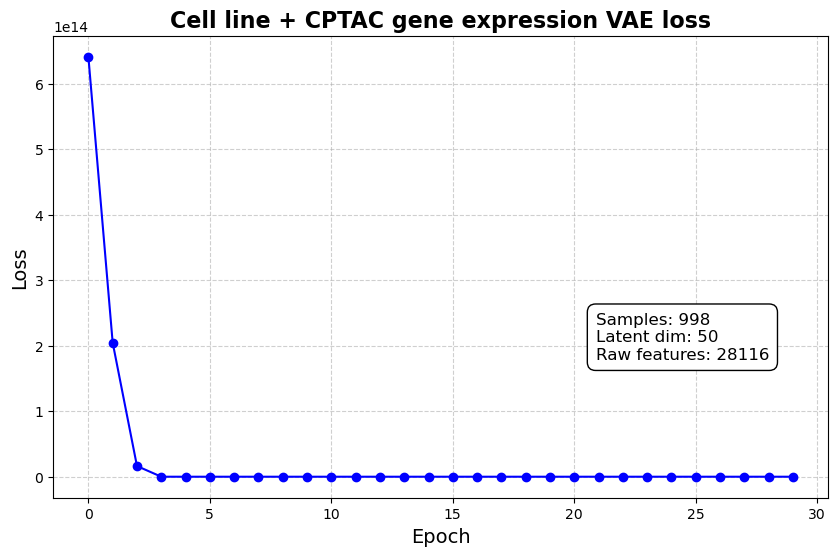

In [35]:
plot_loss(loss_dict, latent_dim, selected_df,
          epochs, platforms, data_type, plot_title)

In [270]:
encdng_sts = 'enc'

In [177]:
mode = 'model_type'

In [189]:
mode = 'cancer_type'

In [183]:
def log_reg(log_reg_obj, mode):
    col_X_strt = 2
    f1_stor_frm = pd.DataFrame()
    
    for i in list(range(0, 5)): # Doing a random split five times
        print(i)
    
        trn = log_reg_obj.sample(round(len(log_reg_obj) * .8))
        tst = log_reg_obj.loc[~log_reg_obj.index.isin(trn.index)]
    
        X_trn = trn.iloc[:, col_X_strt:]
        X_tst = tst.iloc[:, col_X_strt:]
        
        y_trn = trn[mode] # get the y targets
        y_tst = tst[mode]
        
        clf = LogisticRegression().fit(X_trn, y_trn)
        y_pred = clf.predict(X_tst)
        
        f1_by_class = f1_score(y_tst, y_pred, average=None)
        f1_df = pd.DataFrame({'Label': list(y_tst.unique()),
                              'F1_Score': f1_by_class})
        f1_stor_frm = pd.concat([f1_stor_frm, f1_df], axis = 0)
    return f1_stor_frm

In [190]:
f1_stor_frm = log_reg(latent_df, mode)

0
1


/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

2
3


/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

4


/Users/karlberb/miniforge3/envs/py310tf210/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [185]:
f1_stor_frm

,Label,F1_Score
0,Tumor,1.000000
1,cell line,1.000000
0,Tumor,1.000000
1,cell line,1.000000
0,Tumor,1.000000
1,cell line,1.000000
0,Tumor,0.990476
1,cell line,0.963855
0,Tumor,1.000000
1,cell line,1.000000


In [207]:
tcga_colors_df = pd.read_csv('/Users/karlberb/Documents/work/archive/tcga_colors.tsv', sep='\t',
                            index_col = 0)

In [ ]:
# write / read logreg f1 score frame here

In [ ]:
# Log Reg model mode function
def lgrg_plt(f1_stor_frm)
    plt.figure(figsize=(15, 8))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.5)
    
    sns.barplot(x='Label', y='F1_Score', data=f1_stor_frm, palette=['#666666', '#999999'],
               errorbar=None)
    sns.swarmplot(x='Label', y='F1_Score', data=f1_stor_frm, color='#333333', size=12)
    
    plt.title('Model type logistic regression', fontsize=24)
    plt.xlabel('Model Type', fontsize=20)
    plt.ylabel('F1 Score', fontsize=20)
    
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.savefig('../results_encoded/plat.'+plat+'_'+data_name+'_dim.'+str(
                latent_dim)+'_epochs.'+str(
                epochs)+'_mode.'+mode+'.png', bbox_inches='tight')
    return plt.show()

#### LogReg plot model type

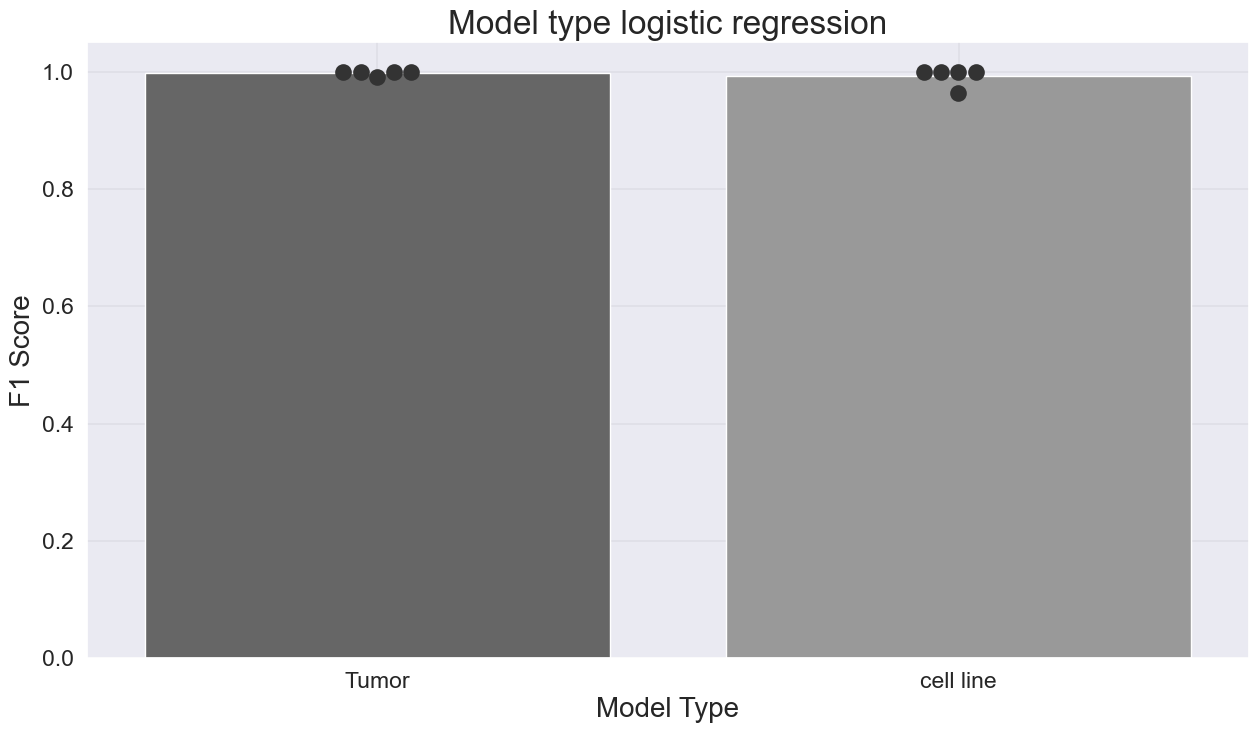

In [188]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

sns.barplot(x='Label', y='F1_Score', data=f1_stor_frm, palette=['#666666', '#999999'],
           errorbar=None)
sns.swarmplot(x='Label', y='F1_Score', data=f1_stor_frm, color='#333333', size=12)

plt.title('Model type logistic regression', fontsize=24)
plt.xlabel('Model Type', fontsize=20)
plt.ylabel('F1 Score', fontsize=20)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig('../results_encoded/plat.'+plat+'_'+data_name+'_dim.'+str(
            latent_dim)+'_epochs.'+str(
            epochs)+'_mode.'+mode+'.png', bbox_inches='tight')

### LogReg plot cancer type

In [208]:
tcga_colors_df

,cohort_color
tcga_cohorts,
ACC,#C1A72F
BLCA,#FAD2D9
BRCA,#ED2891
CESC,#F6B667
COADREAD,#9EDDF9
ESCC,#007EB5
GEA,#909485
HNSC,#97D1A9
KIRCKICH,#F8AFB3


In [200]:
abbreviation_mapping

{'cell line': 'cell line', 'Tumor': 'Tumor'}

In [201]:
abbreviation_mapping = {
    'Clear cell renal cell carcinoma': 'KIRCKICH', # combined chromophobe
    'Colon adenocarcinoma': 'COADREAD', # combined rectal adeno
    'Pancreatic ductal adenocarcinoma': 'PAAD',
    'Breast carcinoma': 'BRCA',
    'Glioblastoma': 'LGGGBM', # combined low grade glioma
    'Lung squamous cell carcinoma': 'LUSC',
    'Lung adenocarcinoma': 'LUAD',
    'Endometrial carcinoma': 'UCEC',
    'Head and neck squamous cell carcinoma': 'HNSC',
    'Ovarian carcinoma': 'OV'
}

In [203]:
f1_stor_frm

,Label,F1_Score
0,Breast carcinoma,0.122449
1,Colon adenocarcinoma,0.108108
2,Lung squamous cell carcinoma,0.050000
3,Lung adenocarcinoma,0.338983
4,Ovarian carcinoma,0.241379
5,Pancreatic ductal adenocarcinoma,0.090909
6,Clear cell renal cell carcinoma,0.162162
0,Breast carcinoma,0.156863
1,Colon adenocarcinoma,0.145455
2,Lung squamous cell carcinoma,0.054054


In [204]:
unique_labels

array(['Breast carcinoma', 'Colon adenocarcinoma',
       'Lung squamous cell carcinoma', 'Lung adenocarcinoma',
       'Ovarian carcinoma', 'Pancreatic ductal adenocarcinoma',
       'Clear cell renal cell carcinoma'], dtype=object)

In [205]:
mapped_colors

['BRCA', 'COADREAD', 'LUSC', 'LUAD', 'OV', 'PAAD', 'KIRCKICH']

In [210]:
mapped_palette

[None, None, None, None, None, None, None]

In [209]:
unique_labels = f1_stor_frm['Label'].unique()
mapped_colors = [abbreviation_mapping.get(label) for label in unique_labels]
mapped_palette = [tcga_colors_df.get(color) for color in mapped_colors]
palette_dict = {label: tcga_colors_df[abbreviation_mapping[label]] for label in unique_labels}

KeyError: 'BRCA'

In [220]:
tcga_color_mapping = pd.read_csv('/Users/karlberb/Documents/work/archive/tcga_colors.tsv', sep='\t',
                            index_col = 0
                            )

In [224]:
unique_labels

array(['Breast carcinoma', 'Colon adenocarcinoma',
       'Lung squamous cell carcinoma', 'Lung adenocarcinoma',
       'Ovarian carcinoma', 'Pancreatic ductal adenocarcinoma',
       'Clear cell renal cell carcinoma'], dtype=object)

In [226]:
label

'Breast carcinoma'

In [227]:
abbreviation_mapping.get(label)

'BRCA'

In [228]:
tcga_color_mapping.head()

,cohort_color
tcga_cohorts,
ACC,#C1A72F
BLCA,#FAD2D9
BRCA,#ED2891
CESC,#F6B667
COADREAD,#9EDDF9


In [230]:
color

In [231]:
tcga_color_mapping = dict(zip(tcga_colors_df['tcga_cohorts'], tcga_colors_df['cohort_color']))

In [232]:
tcga_color_mapping

{'ACC': '#C1A72F',
 'BLCA': '#FAD2D9',
 'BRCA': '#ED2891',
 'CESC': '#F6B667',
 'COADREAD': '#9EDDF9',
 'ESCC': '#007EB5',
 'GEA': '#909485',
 'HNSC': '#97D1A9',
 'KIRCKICH': '#F8AFB3',
 'KIRP': '#EA7075',
 'LGGGBM': '#D49DC7',
 'LIHCCHOL': '#CACCDB',
 'LUAD': '#D3C3E0',
 'LUSC': '#A084BD',
 'MESO': '#542C88',
 'OV': '#D97D25',
 'PAAD': '#6E7BA2',
 'PCPG': '#E8C51D',
 'PRAD': '#7E1918',
 'SARC': '#00A99D',
 'SKCM': '#BBD642',
 'TGCT': '#BE1E2D',
 'THCA': '#F9ED32',
 'THYM': '#CEAC8F',
 'UCEC': '#FBE3C7',
 'UVM': '#009444'}

In [233]:
palette_dict = {}
for label in unique_labels:
    # break
    tcga_abbreviation = abbreviation_mapping.get(label)
    # break
    color = tcga_color_mapping.get(tcga_abbreviation)
    # break
    if color:
        palette_dict[label] = color

In [237]:
f1_stor_frm

,Label,F1_Score
0,Breast carcinoma,0.122449
1,Colon adenocarcinoma,0.108108
2,Lung squamous cell carcinoma,0.050000
3,Lung adenocarcinoma,0.338983
4,Ovarian carcinoma,0.241379
5,Pancreatic ductal adenocarcinoma,0.090909
6,Clear cell renal cell carcinoma,0.162162
0,Breast carcinoma,0.156863
1,Colon adenocarcinoma,0.145455
2,Lung squamous cell carcinoma,0.054054


In [238]:
plat

'cell_line_+_cptac'

In [239]:
data_name

'cnvr'

In [235]:
# Cancer Type Logistic Regression Plot Function
def lgrg_plt(f1_stor_frm):
    plt.figure(figsize=(15, 8))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.5)
    
    sns.barplot(
        x='Label', y='F1_Score', data=f1_stor_frm,
        palette=palette_dict,
        errorbar=None)
    sns.swarmplot(x='Label', y='F1_Score', data=f1_stor_frm,
                  color='#333333', size=12)
    
    plt.title('Model type logistic regression', fontsize=24)
    plt.xlabel('Model Type', fontsize=20)
    plt.ylabel('F1 Score', fontsize=20)
    
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.savefig('../results_encoded/plat.'+plat+'_'+data_name+'_dim.'+str(
                latent_dim)+'_epochs.'+str(
                epochs)+'_mode.'+mode+'.png', bbox_inches='tight')
    return plt.show()

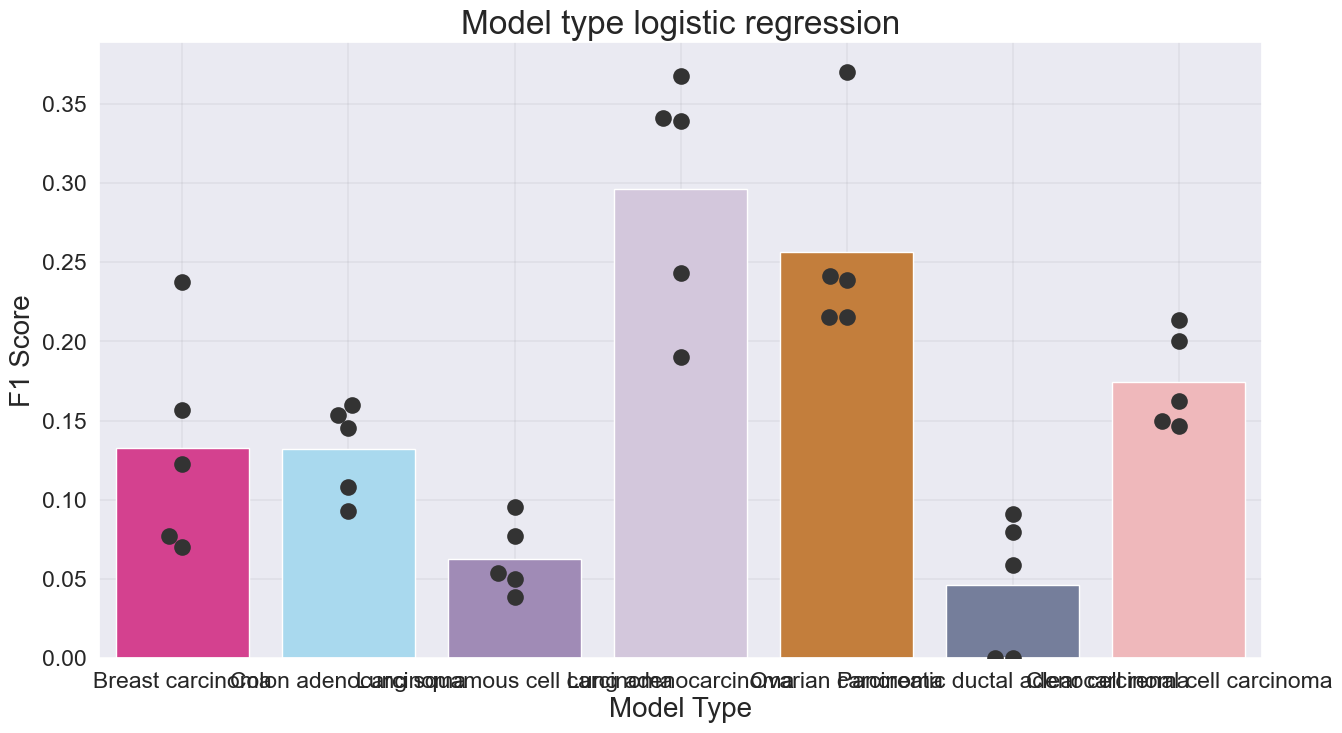

In [236]:
lgrg_plt(f1_stor_frm)

In [ ]:
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define some example parameters for demonstration purposes
plat = "cell_line"
data_name = "cptac_cnvr"
latent_dim = 50
epochs = 30
mode = "cancer_type"

In [247]:
plat

'cell_line_+_cptac'

In [248]:
data_name

'cnvr'

In [249]:
latent_dim

50

In [250]:
epochs

30

In [251]:
mode

'cancer_type'

In [252]:
mode_name = 'Cancer type'

In [253]:
# Modified Cancer Type Logistic Regression Plot Function
def lgrg_plt_fnc(f1_stor_frm, plat, data_name, latent_dim, epochs, mode, mode_name):
    plt.figure(figsize=(20, 10))
    sns.set_style("whitegrid")
    sns.set(font_scale=2)  # Increase the font scale for larger fonts
    
    ax = sns.barplot(
        x='Label', y='F1_Score', data=f1_stor_frm,
        palette=palette_dict,
        errorbar=None)
    sns.swarmplot(x='Label', y='F1_Score', data=f1_stor_frm,
                  color='#333333', size=15)  # Increase point size
    
    plt.title(mode_name+' logistic regression', fontsize=30)  # Increase title font size
    plt.xlabel(mode_name, fontsize=28)  # Increase x-axis label font size
    plt.ylabel('F1 Score', fontsize=28)  # Increase y-axis label font size
    
    plt.xticks(rotation=45, ha = 'right')  # Rotate x-axis labels for better visibility
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    # Modify the save path to use the provided parameters
    plt.savefig('../results_encoded/fnc0_plat.'+plat+'_'+data_name+'_dim.'+str(
                latent_dim)+'_epochs.'+str(
                epochs)+'_mode.'+mode+'.png', bbox_inches='tight')
    plt.show()

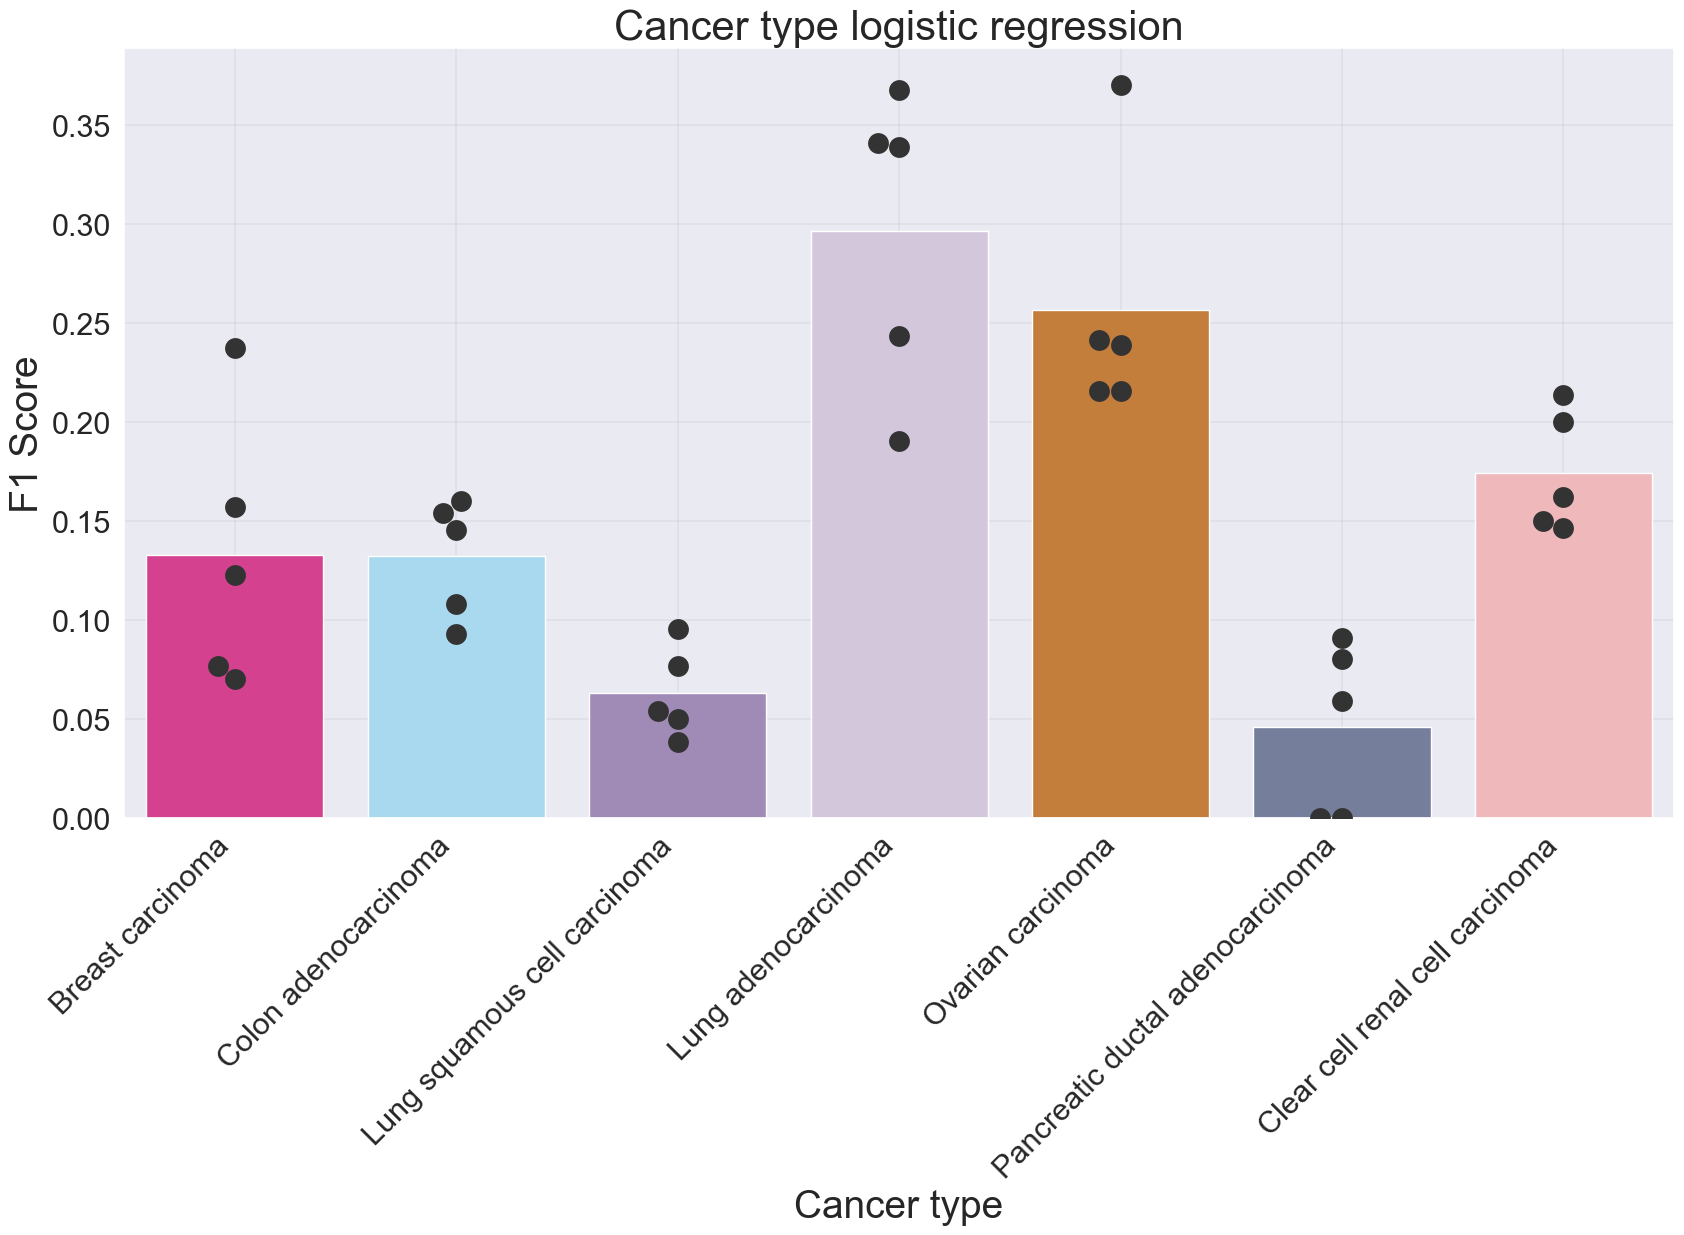

In [255]:
lgrg_plt_fnc(f1_stor_frm, plat, data_name, latent_dim, epochs, mode, mode_name)

#### devel

In [234]:
palette_dict

{'Breast carcinoma': '#ED2891',
 'Colon adenocarcinoma': '#9EDDF9',
 'Lung squamous cell carcinoma': '#A084BD',
 'Lung adenocarcinoma': '#D3C3E0',
 'Ovarian carcinoma': '#D97D25',
 'Pancreatic ductal adenocarcinoma': '#6E7BA2',
 'Clear cell renal cell carcinoma': '#F8AFB3'}

#### Template blocks

In [ ]:
palette_dict = {label: color_mapping[abbreviation_mapping[label]] for label in unique_labels}

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(x='Label', y='F1_Score', data=log_reg_f1_df, palette=palette_dict)
sns.swarmplot(x='Label', y='F1_Score', data=log_reg_f1_df, color='darkgrey')
plt.xticks(rotation=45)
plt.title('F1 Scores by Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('F1 Score')

In [ ]:
def lgrg_plt(f1_stor_frm)
    plt.figure(figsize=(15, 8))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.5)
    
    sns.barplot(x='Label', y='F1_Score', data=f1_stor_frm, palette=['#666666', '#999999'],
               errorbar=None)
    sns.swarmplot(x='Label', y='F1_Score', data=f1_stor_frm, color='#333333', size=12)
    
    plt.title('Model type logistic regression', fontsize=24)
    plt.xlabel('Model Type', fontsize=20)
    plt.ylabel('F1 Score', fontsize=20)
    
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.savefig('../results_encoded/plat.'+plat+'_'+data_name+'_dim.'+str(
                latent_dim)+'_epochs.'+str(
                epochs)+'_mode.'+mode+'.png', bbox_inches='tight')
    return plt.show()

In [272]:
encdng_sts

'enc'

In [ ]:
# know data type at this point, recycle vars 

#### Reset euc_n var between data types

In [315]:
euc_n = latent_df

In [316]:
euc_n

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,1.439899,1.533506,0.628120,0.054526,-0.559137,-0.585355,-1.277910,0.693328,0.570371,0.088946,...,0.199645,0.091887,0.547483,0.072149,2.115180,1.866966,1.284497,0.188087,0.708378,0.007651
108163.0,-0.953706,-0.610869,0.140408,0.183683,0.548320,-0.586559,-0.341316,-0.113022,0.074512,-0.397311,...,-0.099538,0.067979,-1.270018,-0.067538,0.993388,1.163411,1.241985,0.085117,-0.703866,-0.116846
108164.0,0.528911,-3.034726,0.285810,0.079621,-0.191005,-0.294464,-0.154292,-0.603271,1.639294,-0.763550,...,0.030159,0.065285,0.101063,0.196396,0.349092,1.193105,1.093049,0.069530,-0.820990,-0.904080
108165.0,-0.114301,-0.529857,0.385949,0.114382,-0.368625,-0.642673,-0.546929,-0.953669,0.128911,-0.292151,...,-0.053926,0.077217,-1.409377,-0.026639,1.860669,1.069203,1.026686,0.091033,-1.176576,-0.373831
108166.0,0.029109,-0.588236,0.420315,-0.065497,-0.845241,-0.374031,-0.325192,-0.751451,1.378194,-0.131867,...,0.004814,0.002132,-1.038090,-0.079290,1.645097,1.394155,0.990790,-0.008248,0.691237,0.176602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599.0,1.073569,-5.609256,0.673468,-0.236819,-0.654580,-1.610266,-0.887134,-1.008669,0.122534,-0.022692,...,-0.010750,0.115486,-0.303314,-0.262494,1.433354,2.353862,2.949597,0.539274,-0.746637,-1.690494
1600.0,1.457700,-2.708468,0.691975,-0.155513,-0.738500,-1.627340,0.300062,-1.174452,-0.060655,0.034433,...,-0.028800,0.037832,-1.430725,-0.255326,2.557380,2.800176,3.663093,0.470992,-1.035416,-1.604021
1601.0,2.678715,4.606073,0.679786,-0.120099,-0.708968,-1.523231,-0.531936,0.041633,0.094457,-0.377173,...,0.033462,0.152978,-0.122706,-0.257496,1.208074,2.762115,2.343506,0.526297,-1.190930,-1.442815


In [317]:
cl_cp_cnvr_996

,cancer_type,model_type,1.0,2.0,13.0,14.0,16.0,18.0,19.0,20.0,...,105980003.0,106479861.0,106479938.0,106480180.0,106480993.0,106481981.0,110599588.0,112441434.0,122405565.0,125316803.0
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,Breast carcinoma,Tumor,-0.072650,-0.116220,-0.066020,0.091830,0.139840,-0.190880,-0.055800,0.016700,...,-0.178470,0.091830,0.091830,0.091830,-0.020410,-0.005760,0.091830,-0.272700,-0.046020,-0.266960
108163.0,Breast carcinoma,Tumor,-0.066440,0.314130,-0.090750,-0.051920,-0.019530,-0.166190,-0.068200,0.010580,...,-0.043120,-0.051920,-0.051920,-0.051920,-0.075710,-0.066610,-0.051920,-0.075500,0.070210,-0.099460
108164.0,Breast carcinoma,Tumor,0.284680,-0.263720,0.262890,0.216530,0.269190,-0.389280,-0.196390,-0.196390,...,-0.159240,0.216530,0.053630,-0.272270,0.217620,-0.102390,0.216530,-0.263480,-0.115030,0.284810
108165.0,Breast carcinoma,Tumor,0.003700,-0.003320,-0.007440,0.139350,0.051430,-0.047940,0.089450,0.089450,...,0.039000,0.139350,0.139350,0.139350,-0.009400,0.091440,0.139350,-0.011510,0.003700,-0.175980
108166.0,Breast carcinoma,Tumor,0.096100,0.037510,0.099620,-0.236890,0.135520,0.264650,-0.117420,0.099580,...,0.122140,-0.236890,-0.236890,-0.236890,-0.247420,0.098260,-0.236890,0.070210,-0.210850,-0.231830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599.0,Clear cell renal cell carcinoma,cell line,0.991330,0.987027,0.982139,0.989569,1.190990,1.190990,1.031283,1.031283,...,0.993150,0.989569,0.989569,0.989569,0.987201,0.976031,0.989569,1.104300,0.991330,0.974191
1600.0,Clear cell renal cell carcinoma,cell line,1.025435,1.020126,1.002917,0.989082,1.051277,0.984148,1.016712,1.022126,...,0.979679,0.989082,0.989082,0.989082,1.019652,0.981697,0.989082,0.964601,1.025435,0.979814
1601.0,Clear cell renal cell carcinoma,cell line,1.088740,1.098864,1.112800,0.905957,1.005205,0.905069,0.676913,0.676913,...,0.954895,0.905957,0.905957,0.905957,0.911477,0.670966,0.905957,1.051294,1.090995,0.662120


In [318]:
latent_df.insert(
    loc=0, column='cancer_type',
    value=cl_cp_cnvr_996['cancer_type'])
latent_df.insert(
    loc=1, column='model_type',
    value=cl_cp_cnvr_996['model_type'])

In [319]:
latent_df

,cancer_type,model_type,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,Breast carcinoma,Tumor,1.439899,1.533506,0.628120,0.054526,-0.559137,-0.585355,-1.277910,0.693328,...,0.199645,0.091887,0.547483,0.072149,2.115180,1.866966,1.284497,0.188087,0.708378,0.007651
108163.0,Breast carcinoma,Tumor,-0.953706,-0.610869,0.140408,0.183683,0.548320,-0.586559,-0.341316,-0.113022,...,-0.099538,0.067979,-1.270018,-0.067538,0.993388,1.163411,1.241985,0.085117,-0.703866,-0.116846
108164.0,Breast carcinoma,Tumor,0.528911,-3.034726,0.285810,0.079621,-0.191005,-0.294464,-0.154292,-0.603271,...,0.030159,0.065285,0.101063,0.196396,0.349092,1.193105,1.093049,0.069530,-0.820990,-0.904080
108165.0,Breast carcinoma,Tumor,-0.114301,-0.529857,0.385949,0.114382,-0.368625,-0.642673,-0.546929,-0.953669,...,-0.053926,0.077217,-1.409377,-0.026639,1.860669,1.069203,1.026686,0.091033,-1.176576,-0.373831
108166.0,Breast carcinoma,Tumor,0.029109,-0.588236,0.420315,-0.065497,-0.845241,-0.374031,-0.325192,-0.751451,...,0.004814,0.002132,-1.038090,-0.079290,1.645097,1.394155,0.990790,-0.008248,0.691237,0.176602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599.0,Clear cell renal cell carcinoma,cell line,1.073569,-5.609256,0.673468,-0.236819,-0.654580,-1.610266,-0.887134,-1.008669,...,-0.010750,0.115486,-0.303314,-0.262494,1.433354,2.353862,2.949597,0.539274,-0.746637,-1.690494
1600.0,Clear cell renal cell carcinoma,cell line,1.457700,-2.708468,0.691975,-0.155513,-0.738500,-1.627340,0.300062,-1.174452,...,-0.028800,0.037832,-1.430725,-0.255326,2.557380,2.800176,3.663093,0.470992,-1.035416,-1.604021
1601.0,Clear cell renal cell carcinoma,cell line,2.678715,4.606073,0.679786,-0.120099,-0.708968,-1.523231,-0.531936,0.041633,...,0.033462,0.152978,-0.122706,-0.257496,1.208074,2.762115,2.343506,0.526297,-1.190930,-1.442815


In [320]:
feature_columns = euc_n.columns[2:]
euc_n['mdl_typ_dstncs'] = euc_n.apply(
    lambda row: mdl_typ_dist(row, feature_columns, euc_n), axis=1)
euc_n['cncr_typ_dstncs'] = euc_n.apply(
    lambda row: cncr_typ_dist(row, feature_columns, euc_n), axis=1)
new_cols = ['cancer_type', 'model_type', 'cncr_typ_dstncs', 'mdl_typ_dstncs'] + list(feature_columns)
euc_n = euc_n[new_cols]

In [321]:
euc_n # good, keep, 2023-09-22

,cancer_type,model_type,cncr_typ_dstncs,mdl_typ_dstncs,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,Breast carcinoma,Tumor,16.348655,32.727076,1.439899,1.533506,0.628120,0.054526,-0.559137,-0.585355,...,0.199645,0.091887,0.547483,0.072149,2.115180,1.866966,1.284497,0.188087,0.708378,0.007651
108163.0,Breast carcinoma,Tumor,17.218782,18.775142,-0.953706,-0.610869,0.140408,0.183683,0.548320,-0.586559,...,-0.099538,0.067979,-1.270018,-0.067538,0.993388,1.163411,1.241985,0.085117,-0.703866,-0.116846
108164.0,Breast carcinoma,Tumor,8.318765,26.687028,0.528911,-3.034726,0.285810,0.079621,-0.191005,-0.294464,...,0.030159,0.065285,0.101063,0.196396,0.349092,1.193105,1.093049,0.069530,-0.820990,-0.904080
108165.0,Breast carcinoma,Tumor,16.241021,40.592178,-0.114301,-0.529857,0.385949,0.114382,-0.368625,-0.642673,...,-0.053926,0.077217,-1.409377,-0.026639,1.860669,1.069203,1.026686,0.091033,-1.176576,-0.373831
108166.0,Breast carcinoma,Tumor,21.657577,38.186666,0.029109,-0.588236,0.420315,-0.065497,-0.845241,-0.374031,...,0.004814,0.002132,-1.038090,-0.079290,1.645097,1.394155,0.990790,-0.008248,0.691237,0.176602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599.0,Clear cell renal cell carcinoma,cell line,244.127197,246.334473,1.073569,-5.609256,0.673468,-0.236819,-0.654580,-1.610266,...,-0.010750,0.115486,-0.303314,-0.262494,1.433354,2.353862,2.949597,0.539274,-0.746637,-1.690494
1600.0,Clear cell renal cell carcinoma,cell line,266.999794,271.470495,1.457700,-2.708468,0.691975,-0.155513,-0.738500,-1.627340,...,-0.028800,0.037832,-1.430725,-0.255326,2.557380,2.800176,3.663093,0.470992,-1.035416,-1.604021
1601.0,Clear cell renal cell carcinoma,cell line,91.200281,86.140240,2.678715,4.606073,0.679786,-0.120099,-0.708968,-1.523231,...,0.033462,0.152978,-0.122706,-0.257496,1.208074,2.762115,2.343506,0.526297,-1.190930,-1.442815


#### Toggle vars

In [324]:
quant_mode = 'model_type' # model type, left to right, this is a black and white ridgeline plot
dist_typ = 'mdl_typ_dstncs'
quant_ttl = 'Model Type'
mode = 'model_type'

In [ ]:
quant_mode = 'cancer_type'
dist_typ = 'cncr_typ_dstncs'
quant_ttl = 'Cancer Type'

In [ ]:
mode = 'cancer_type'

In [325]:
plat # where is this from, what else is there?

'cell_line_+_cptac'

#### Average distances

In [330]:
quant_mode # want greyscale here for model_type
            # want TCGA colors for cancer_type

'model_type'

In [331]:
dist_typ

'mdl_typ_dstncs'

#### devel record

In [283]:
euc_n.groupby('model_type')['mdl_typ_dstncs'].mean() # Failure mode

,mdl_typ_dstncs,mdl_typ_dstncs
model_type,,
Tumor,337.222562,337.222562
cell line,422.125635,422.125635


In [328]:
euc_n.head(1)

,cancer_type,model_type,cncr_typ_dstncs,mdl_typ_dstncs,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,Breast carcinoma,Tumor,16.348655,32.727076,1.439899,1.533506,0.62812,0.054526,-0.559137,-0.585355,...,0.199645,0.091887,0.547483,0.072149,2.11518,1.866966,1.284497,0.188087,0.708378,0.007651


In [329]:
average_distances = euc_n.groupby('model_type')['mdl_typ_dstncs'].mean().sort_values(ascending=False) # Failure mode corrected, dupe columns inserted

In [ ]:
#### Look at both labels

In [266]:
latent_df.model_type.unique()

array(['Tumor', 'cell line'], dtype=object)

In [267]:
latent_df.cancer_type.unique()

array(['Breast carcinoma', 'Colon adenocarcinoma',
       'Lung squamous cell carcinoma', 'Lung adenocarcinoma',
       'Ovarian carcinoma', 'Pancreatic ductal adenocarcinoma',
       'Clear cell renal cell carcinoma'], dtype=object)

#### continue ridgeline

In [ ]:
# check-in goal: mdl_sys_correction_v0, on GEXP - polished notebook

In [332]:
average_distances = euc_n.groupby(quant_mode)[dist_typ].mean().sort_values(ascending=False) # Auto mode, keep for v2

In [333]:
average_distances 

model_type
cell line    260.804179
Tumor         35.866546
Name: mdl_typ_dstncs, dtype: float64

In [334]:
sorted_df = euc_n.loc[euc_n[quant_mode].isin(average_distances.index)]
sorted_df[quant_mode] = pd.Categorical(
    sorted_df[quant_mode], categories=average_distances.index, ordered=True)
sorted_df = sorted_df.sort_values(quant_mode)

In [260]:
d_typ = 'cnvr'

#### Set parameters

In [263]:
grey_colors = pd.DataFrame({'quant_mode_color': ['#999999', '#666666']},
                           index = ['cell line', 'Tumor'])

In [264]:
tcga_colors

,cohort_color
tcga_cohorts,
ACC,#C1A72F
BLCA,#FAD2D9
BRCA,#ED2891
CESC,#F6B667
COADREAD,#9EDDF9
ESCC,#007EB5
GEA,#909485
HNSC,#97D1A9
KIRCKICH,#F8AFB3


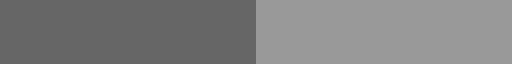

In [335]:
custom_colormap # set at start of log reg bar plot

In [336]:
pwd

'/Users/karlberb/Documents/work/IMPROVE/pipeline_7/production_code'

In [337]:
ls

cell_line_histo.png       front_end_plots_v0.ipynb  front_end_plots_v1.ipynb


In [338]:
ls ..

Encodable_label_terms.drawio  devel_code/
Encodable_label_terms.png     production_code/
code_templates/               readme.txt
composite_loss_vae.pptx       results/
conda_notes.txt               results_encoded/


In [346]:
y_values

array([0.65, 0.2 ])

<Figure size 640x480 with 0 Axes>

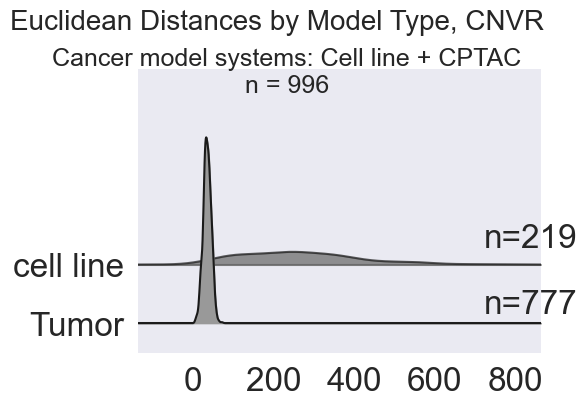

In [349]:
plt.figure()
joyplot(
    data=sorted_df[[quant_mode, dist_typ]], by=quant_mode,
    figsize=(6, 4), colormap=custom_colormap, fade=True
    )
# y_values = np.linspace(0.8, 0.068, 7)
y_values = np.linspace(0.4, 0.17, 2)

for y_value, cancer_type in zip(y_values, sorted_df[quant_mode].unique()):
    count = dict(sorted_df[quant_mode].value_counts())[cancer_type]
    x_position = sorted_df[dist_typ].max()
    plt.annotate(f"n={count}", xy=(x_position, y_value), verticalalignment='center')

plt.suptitle('Euclidean Distances by '+quant_ttl+', '+data_ttl,
             # x = 0.1,
             y = 1.06,
             fontsize = 20
            )
plt.title('Cancer model systems: '+mdl_ttl+
          # '\nData type: '+dta_ttl+
          '\nn = '+str(euc_n.shape[0]),
            x = .37, y = .89, fontsize = 18
         )
plt.savefig('../results_encoded/rdgln_'+quant_mode+'_'+plat+'_'+data_name+'.png', bbox_inches = 'tight',
           dpi = 300)